ランダムフォレストは、決定木を複数用意して多数決で識別する、クラス分類手法

データはこれまで同様にXOR

In [1]:
# ライブラリのインポート--------------------------------
import numpy as np #numpyという行列などを扱うライブラリを利用
import pandas as pd #pandasというデータ分析ライブラリを利用
import matplotlib.pyplot as plt #プロット用のライブラリを利用
from sklearn import ensemble, metrics, preprocessing, cross_validation #機械学習用のライブラリを利用
from mlxtend.plotting import plot_decision_regions #学習結果をプロットする外部ライブラリを利用

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# XORのデータを作成する(x=正、y=正)=0,(x=正、y=負)=1, 的な--------------
np.random.seed(0)
X_xor=np.random.randn(200,2) 
y_xor=np.logical_xor(X_xor[:,0]>0, X_xor[:,1]>0)
y_xor=np.where(y_xor,1,0)
pd.DataFrame(y_xor)  #この行を実行するとデータが見れる

,0
0,0
1,0
2,1
3,1
4,1
5,0
6,0
7,0
8,1
9,1


<function matplotlib.pyplot.show>

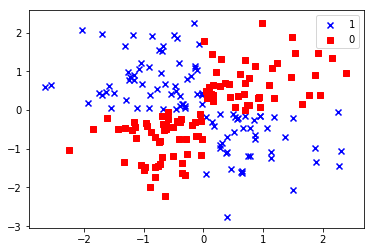

In [3]:
# プロットしてみる------------------------------------------------------
%matplotlib inline
 
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='r', marker='s', label='0')
plt.legend(loc='best')
plt.show

In [4]:
# データの整形-------------------------------------------------------
X_std=X_xor
z=y_xor

# 正規化
sc = preprocessing.StandardScaler()
sc.fit(X_std)
X_std = sc.transform(X_std)

識別器としてランダムフォレストを使用する。

決定木を作成する指標としては「エントロピー」を使用。
決定木は10本作成して、多数決する。

乱数のシードは1で固定。

CPUのコア8つを使用して並列で計算する。

クラスごとのサンプル数に偏りがある分は補正する。

In [5]:
# 機械学習で分類する---------------------------------------------------
clf_result=ensemble.RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=8,class_weight="balanced")
clf_result.fit(X_std, z)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=8, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [6]:
# K分割交差検証（cross validation）で性能を評価する---------------------
scores=cross_validation.cross_val_score(clf_result, X_std, z, cv=10)
print("平均正解率 = ", scores.mean())
print("正解率の標準偏差 = ", scores.std())

平均正解率 =  0.9597368421052632
正解率の標準偏差 =  0.049049836152558125


正答率 =  1.0


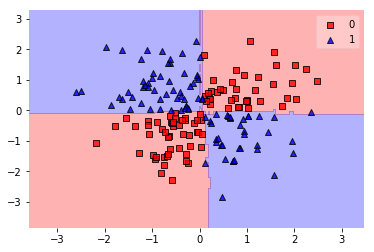

In [7]:
# トレーニングデータとテストデータに分けて実行してみる------------------
X_train, X_test, train_label, test_label=cross_validation.train_test_split(X_std,z, test_size=0.1, random_state=0)
clf_result.fit(X_train, train_label)

#正答率を求める
pre=clf_result.predict(X_test)
ac_score=metrics.accuracy_score(test_label,pre)
print("正答率 = ",ac_score)

#plotする
X_train_plot=np.vstack(X_train)
train_label_plot=np.hstack(train_label)
X_test_plot=np.vstack(X_test)
test_label_plot=np.hstack(test_label)
plot_decision_regions(X_train_plot, train_label_plot, clf=clf_result, res=0.01) #学習データをプロット

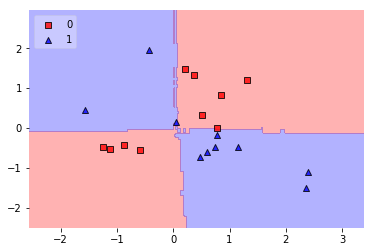

In [8]:
plot_decision_regions(X_test_plot, test_label_plot, clf=clf_result, res=0.01, legend=2) #テストデータをプロット

#### ランダムフォレストとは
 - [random Forest:sklearn](http://scikit-learn.org/stable/modules/ensemble.html)
 - [random Forest:sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

ランダムフォレストは決定木を複数作成し、その多数決で識別結果を決める手法。  
決定木とは、特徴量に対して、単純な識別条件で2分類を繰り返す識別手法。

今回の例では特徴量は2次元の$(x,y)$であるため $x>a or not$ でまず第一段階の識別をし、その後、$y>b or not$ で第二段階の識別を行うことで最終的にクラス0か1かを決定する。

特に今回はXORであるため、$x>0, y>0$ と $x<0, y<0$ を使えば完璧に分類できることになる。

ここで「xで分類するのか、yで分類するのか、そしてその基準となるaやbの値をどう決めるのか？」が問題となるが、今回はエントロピーを用いている。  
その他にジニ不純度なども用いられる。

詳細はおいておくとして、分ける前はクラス0,1がごちゃごちゃ入っているのが、できるだけクラス0だけとクラス1だけに分かれる基準を探していき、きれいに分かれている度合いを、エントロピーやジニ不純度で測定する。  
これが決定木による識別手法となる。

複数作成するということで、これでは同じ決定木が10本できることになる。  
そうならないようにランダムフォレストではブーストストラップ・サンプリングという手法を使用する。

これは学習データの数がNのとき、学習データから適当にN個をとってくる手法。  
このときに同じデータを何度もとってくることを許し、N個からN個をとっても、毎回少し異なる学習データが得られることになる。  
こうしてサンプリングしたN個のデータに対して決定木を作成する、という操作をN個の取り方を変えながら、今回であれば10回おこない、10本の決定木を作成している。

テストデータに対してはこの10本の決定木で識別をして10個の識別結果を求め、多数決で最終的なクラスを決定する。